# Volatility & Volume Scaling

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import io
import time
import warnings
import scipy.optimize as sco
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, HTML, clear_output
from google.colab import output  # <--- CRITICAL FOR JS BRIDGE

# ==========================================
# 1. CONFIGURATION & STYLE
# ==========================================
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

# ==========================================
# 2. THE LOGIC CLASS
# ==========================================
class SentimentPortfolioEngine:
    def __init__(self, api_key):
        self.api_key = api_key
        print("⏳ Loading BERT Model (this may take 10-20 seconds)...")
        self.tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        print("✅ Model Loaded.")

    def fetch_news_and_filter(self, tickers, start_date_str, lookback_days=30, min_articles=5):
        # Fetch data starting 30 days BEFORE the user's start date (for training context)
        start_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
        fetch_start_dt = start_dt - timedelta(days=lookback_days)
        fetch_start_str = fetch_start_dt.strftime('%Y-%m-%d')

        print(f"\n📡 Fetching news from {fetch_start_str} (Lookback) to Present...")
        valid_tickers = []
        news_map = {}
        end_date_str = datetime.now().strftime('%Y-%m-%d')

        for ticker in tickers:
            try:
                time.sleep(0.2) # Rate limit kindness
                url = (f"https://finnhub.io/api/v1/company-news?"
                       f"symbol={ticker}&from={fetch_start_str}&to={end_date_str}&token={self.api_key}")

                response = requests.get(url)
                data = response.json()

                news_items = []
                if isinstance(data, list):
                    for art in data:
                        ts = art.get('datetime')
                        if ts:
                            pub_date = datetime.fromtimestamp(ts)
                            text = f"{art.get('headline', '')}. {art.get('summary', '')}"
                            news_items.append({'datetime': pub_date, 'full_text': text})

                if len(news_items) >= min_articles:
                    df = pd.DataFrame(news_items)
                    df = df.set_index('datetime').sort_index()
                    news_map[ticker] = df
                    valid_tickers.append(ticker)

                    # DEBUG INFO
                    d_min = df.index.min().date()
                    d_max = df.index.max().date()
                    print(f"   ✅ {ticker}: {len(news_items)} articles found (Range: {d_min} to {d_max})")
                else:
                    print(f"   ⚠️ {ticker}: No news found. Generating synthetic data for demo.")
                    valid_tickers.append(ticker)
                    # Synthetic Data Generator for Demo Purposes
                    dates = pd.date_range(start=fetch_start_str, end=end_date_str, freq='D')
                    dummy_texts = ["Market is bullish and strong.", "Earnings were poor and bearish.", "Neutral market update."]
                    dummy_data = [np.random.choice(dummy_texts) for _ in range(len(dates))]
                    dummy_df = pd.DataFrame({'datetime': dates, 'full_text': dummy_data})
                    news_map[ticker] = dummy_df.set_index('datetime')
            except Exception as e:
                print(f"   ⚠️ Error fetching {ticker}: {e}")

        return valid_tickers, news_map

    def analyze_sentiment(self, text):
        # Continuous Scoring Logic
        if not text: return 0.0
        inputs = self.tokenizer(str(text)[:512], return_tensors="pt", truncation=True, padding=True)

        with torch.no_grad():
            logits = self.model(**inputs).logits

        # Convert Logits to Probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)

        # Weighted Average of Stars (1..5)
        stars = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
        expected_rating = torch.sum(probs * stars).item()

        # Normalize (1..5) -> (-1..1)
        return (expected_rating - 3) / 2

    def get_market_data(self, tickers, start_date):
        print(f"\n📈 Downloading Market Data [{start_date} to Present]...")
        factor_etfs = ['MTUM', 'QUAL', 'VLUE', 'USMV', 'SPY']
        all_tickers = list(set(tickers + factor_etfs))

        # yfinance download
        data = yf.download(all_tickers, start=start_date, auto_adjust=False, progress=False)['Adj Close']

        if data.empty:
            raise ValueError("No market data downloaded. Check Tickers or Date.")
        return data.pct_change().dropna(), factor_etfs

    def perform_pca(self, returns_df, factor_etfs):
        # Filter for factors that actually downloaded
        valid_factors = [f for f in factor_etfs if f in returns_df.columns]
        if not valid_factors: return pd.DataFrame()

        factor_data = returns_df[valid_factors]
        scaler = StandardScaler()
        # Fit PCA to explain 95% of variance
        pca = PCA(n_components=0.95)
        principal_components = pca.fit_transform(scaler.fit_transform(factor_data))

        cols = [f'PC_{i+1}' for i in range(principal_components.shape[1])]
        return pd.DataFrame(data=principal_components, columns=cols, index=factor_data.index)

    def optimize_portfolio(self, mean_returns, cov_matrix):
        num_assets = len(mean_returns)
        args = (mean_returns, cov_matrix)

        def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
            p_ret = np.sum(mean_returns * weights)
            p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return -(p_ret) / p_vol if p_vol > 1e-6 else 0

        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0, 1.0) for asset in range(num_assets))
        init_guess = num_assets * [1. / num_assets,]

        try:
            result = sco.minimize(neg_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-5)
            return result.x
        except:
            return np.array(init_guess)

    def run_analysis(self, tickers, stock_start, news_start, alpha_factor):
        # 1. Fetch News
        valid_tickers, news_map = self.fetch_news_and_filter(tickers, news_start)
        if not valid_tickers:
            print("❌ No valid tickers found.")
            return

        # =====================================================
        # AUTO-ALIGNMENT: Check for Date Mismatches
        # =====================================================
        start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')
        for ticker in valid_tickers:
            df = news_map[ticker]
            if df.empty: continue

            # If data starts AFTER the simulation date (Future Data), shift it back
            # Or if data ends way BEFORE simulation date (Old Data)
            # Heuristic: If we have NO data in the [start-45, start] window, but we have data elsewhere, move it.

            latest_news_date = df.index.max()
            # If the latest news is in the future relative to sim date:
            if latest_news_date > start_dt_obj:
                print(f"   🔧 Fixing Future Data for {ticker}: Shifting dates back to end at {news_start}...")
                shift_delta = start_dt_obj - latest_news_date
                df.index = df.index + shift_delta
                news_map[ticker] = df

            # Also handle if data is too old (e.g. ended a year ago)
            elif (start_dt_obj - latest_news_date).days > 60:
                print(f"   🔧 Fixing Old Data for {ticker}: Shifting dates forward to end at {news_start}...")
                shift_delta = start_dt_obj - latest_news_date
                df.index = df.index + shift_delta
                news_map[ticker] = df

        # 2. Market Data
        market_returns, factor_etfs = self.get_market_data(valid_tickers, stock_start)
        stock_returns = market_returns[valid_tickers]

        # 3. PCA & Baseline Generation
        pca_factors_df = self.perform_pca(market_returns, factor_etfs)

        # Calculate Baseline Expected Returns (using PCA regression)
        er_base_map = {}
        for ticker in valid_tickers:
            y = stock_returns[ticker]
            common = y.index.intersection(pca_factors_df.index)
            if len(common) > 50:
                X = sm.add_constant(pca_factors_df.loc[common])
                model = sm.OLS(y.loc[common], X).fit()
                er_base_map[ticker] = model.predict(X).mean()
            else:
                er_base_map[ticker] = y.mean()

        er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
        cov_full = stock_returns.cov()

        # Optimize Baseline Portfolio
        w_base = self.optimize_portfolio(er_base_vector, cov_full)

        # 4. FIXED WINDOW Processing with Volatility & Volume Scaling
        print("\n🧠 Processing Sentiment with Log-Volume & Vol-Scaling...")

        # Calculate annualized volatility for the scaling term
        # (Assuming 252 trading days)
        ann_vol = stock_returns.std() * np.sqrt(252)

        processed_news = {}
        for ticker in valid_tickers:
            df = news_map[ticker].copy()
            df['sentiment'] = df['full_text'].apply(self.analyze_sentiment)
            processed_news[ticker] = df

        windows = [15, 20, 30]
        results_store = {}
        sentiment_summary = {ticker: {} for ticker in valid_tickers}

        for w in windows:
            start_window_date = start_dt_obj - timedelta(days=w)
            end_window_date = start_dt_obj

            alpha_adjustments = []

            for ticker in valid_tickers:
                df = processed_news[ticker]
                mask = (df.index >= start_window_date) & (df.index <= end_window_date)
                window_df = df.loc[mask]

                # DEBUG
                if window_df.empty:
                     print(f"      ⚠️ Window Empty: {ticker} ({start_window_date.date()} to {end_window_date.date()})")

                # N = Number of articles in window
                N = len(window_df)
                avg_s = window_df['sentiment'].mean() if N > 0 else 0.0
                sigma = ann_vol[ticker]

                # YOUR NEW EQUATION:
                # Adj = Sentiment * (Alpha * 0.01) * log(1 + N) * (0.20 / sigma)
                adj = avg_s * (alpha_factor * 0.01) * np.log(1 + N) * (0.20 / sigma)

                sentiment_summary[ticker][f'{w}-Day Avg'] = avg_s
                alpha_adjustments.append(adj)

            # Re-optimize with the new adjustment
            er_new = er_base_vector + np.array(alpha_adjustments)
            w_opt = self.optimize_portfolio(er_new, cov_full)
            results_store[w] = w_opt

        # 5. Output Table: Sentiment
        sent_df = pd.DataFrame(sentiment_summary).T

        # 6. Performance Simulation
        # Simulate how these weights would have performed from news_start to Today
        sim_returns = stock_returns.loc[stock_returns.index >= news_start]
        base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

        perf_data = {'Baseline': base_cum}
        spread_data = {}

        for w in windows:
            strat_cum = (1 + sim_returns.dot(results_store[w])).cumprod() - 1
            perf_data[f'{w}-Day Strategy'] = strat_cum
            spread_data[f'{w}-Day Spread'] = strat_cum - base_cum

       # 7. Visualization: Clean & Distinct Lines
        fig_perf, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

        # High-contrast color palette
        # Baseline = Black, 15d = Blue, 30d = Red, 45d = Green
        strategy_colors = ['#0072B2', '#D55E00', '#009E73']

        # Panel 1: Cumulative Returns
        ax1.plot(base_cum, label='Baseline (No Sentiment)', color='#000000', ls='--', lw=3, alpha=0.8)

        for i, w in enumerate(windows):
            label = f'Sentiment Strategy ({w}d)'
            ax1.plot(perf_data[f'{w}-Day Strategy'], label=label, color=strategy_colors[i], lw=2.5)

        ax1.set_title("1. Cumulative Portfolio Performance", fontsize=16, fontweight='bold', pad=15)
        ax1.set_ylabel("Cumulative Return", fontsize=12)
        ax1.legend(loc="upper left", frameon=True, shadow=True)
        ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
        ax1.grid(True, which='both', linestyle=':', alpha=0.5)

        # Panel 2: The Spread (NO SHADING)
        # Horizontal zero line for reference
        ax2.axhline(0, color='#555555', lw=2, zorder=1)

        for i, w in enumerate(windows):
            label = f'Alpha vs Baseline ({w}d)'
            ax2.plot(spread_data[f'{w}-Day Spread'], label=label, color=strategy_colors[i], lw=2.5, zorder=2)

        ax2.set_title("2. Strategy Alpha (Excess Return vs. Baseline)", fontsize=16, fontweight='bold', pad=15)
        ax2.set_ylabel("Return Difference", fontsize=12)
        ax2.legend(loc="upper left", frameon=True, shadow=True)
        ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
        ax2.grid(True, which='both', linestyle=':', alpha=0.5)

        plt.tight_layout()
        plt.show()

        # 8. Final Weights Display
        w_df = pd.DataFrame(index=valid_tickers)
        w_df['Baseline'] = w_base
        for w in windows:
            w_df[f'Sent_{w}d'] = results_store[w]

        # Display Styled DataFrames
        print("\n📊 SENTIMENT SCORES (Raw):")
        display(sent_df.style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1).format("{:.4f}"))

        print("\n⚖️ FINAL OPTIMIZED WEIGHTS:")
        display(w_df.style.background_gradient(cmap='Blues').format("{:.2%}"))

# ==========================================
# 3. INITIALIZATION
# ==========================================
# Use the demo key provided in your snippet
API_KEY = 'd07rf49r01qp8st5v9s0d07rf49r01qp8st5v9sg'
engine = SentimentPortfolioEngine(API_KEY)

# ==========================================
# 4. JAVASCRIPT BRIDGE & UI
# ==========================================

def bridge_function(tickers_str, stock_date, news_date, alpha_val):
    """
    This function is called by JavaScript.
    It parses inputs and triggers the python engine.
    """
    # Clear previous output to keep the dashboard clean
    clear_output(wait=True)

    # Re-display the dashboard header so it doesn't disappear
    display(HTML(dashboard_html))

    print(f"🚀 STARTING ANALYSIS...")
    print(f"   Tickers: {tickers_str}")
    print(f"   Alpha: {alpha_val}")

    # Parse inputs
    tickers = [t.strip().upper() for t in tickers_str.split(',')]
    try:
        alpha = float(alpha_val)
    except:
        alpha = 0.5

    # Run the Engine
    engine.run_analysis(tickers, stock_date, news_date, alpha)

# Register the callback so JS can find it
output.register_callback('notebook.run_sentiment_analysis', bridge_function)

# HTML/CSS for the Dashboard
dashboard_html = """
<style>
    .dash-container {
        font-family: 'Segoe UI', sans-serif;
        background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
        padding: 30px;
        border-radius: 15px;
        box-shadow: 0 10px 20px rgba(0,0,0,0.1);
        max-width: 800px;
        margin: 0 auto;
    }
    .dash-header {
        text-align: center;
        color: #2c3e50;
        margin-bottom: 25px;
    }
    .dash-header h2 { margin: 0; font-size: 24px; }
    .dash-header p { color: #555; font-size: 14px; }

    .input-grid {
        display: grid;
        grid-template-columns: 1fr 1fr;
        gap: 20px;
        margin-bottom: 25px;
    }
    .input-group {
        background: white;
        padding: 15px;
        border-radius: 8px;
        box-shadow: 0 2px 5px rgba(0,0,0,0.05);
    }
    .input-group label {
        display: block;
        font-weight: bold;
        color: #34495e;
        margin-bottom: 8px;
        font-size: 13px;
    }
    .input-group input {
        width: 100%;
        padding: 10px;
        border: 1px solid #ddd;
        border-radius: 4px;
        box-sizing: border-box;
        font-size: 14px;
    }
    .full-width { grid-column: span 2; }

    .btn-run {
        width: 100%;
        padding: 15px;
        background-color: #3498db;
        color: white;
        border: none;
        border-radius: 8px;
        font-size: 16px;
        font-weight: bold;
        cursor: pointer;
        transition: background 0.3s;
        text-transform: uppercase;
        letter-spacing: 1px;
    }
    .btn-run:hover { background-color: #2980b9; }
    .status { text-align: center; margin-top: 15px; color: #666; font-style: italic; display:none;}
</style>

<div class="dash-container">
    <div class="dash-header">
        <h2>📊 Sentiment Alpha Dashboard</h2>
        <p>PCA Factor Models + BERT NLP Optimization</p>
    </div>

    <div class="input-grid">
        <div class="input-group full-width">
            <label>Stock Tickers (Comma Separated)</label>
            <input type="text" id="tickers" value="AAPL, MSFT, NVDA, AMZN, GOOGL, TSLA">
        </div>

        <div class="input-group">
            <label>Training Start Date (History)</label>
            <input type="date" id="stockDate" value="2022-01-01">
        </div>

        <div class="input-group">
            <label>Simulation Start Date (News)</label>
            <input type="date" id="newsDate" value="2025-06-01">
        </div>

        <div class="input-group full-width">
            <label>Alpha Sensitivity (0.1 - 2.0)</label>
            <input type="number" id="alpha" step="0.1" value=".50">
            <small style="color:#777;">Higher values tilt portfolio more aggressively based on sentiment.</small>
        </div>
    </div>

    <button class="btn-run" onclick="triggerPython()">🚀 Run Optimization</button>
    <div id="status" class="status">Processing... check Python output below.</div>
</div>

<script>
    function triggerPython() {
        // Show status
        document.getElementById('status').style.display = 'block';

        // Get values
        var tickers = document.getElementById('tickers').value;
        var stockDate = document.getElementById('stockDate').value;
        var newsDate = document.getElementById('newsDate').value;
        var alpha = document.getElementById('alpha').value;

        // Call Python
        google.colab.kernel.invokeFunction(
            'notebook.run_sentiment_analysis', // Function name
            [tickers, stockDate, newsDate, alpha], // Arguments
            {} // kwargs
        );
    }
</script>
"""

# Display the UI
display(HTML(dashboard_html))

⏳ Loading BERT Model (this may take 10-20 seconds)...


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

✅ Model Loaded.


# Experiment

# news sentient

In [ ]:

import requests
!pip install finnhub-python
import pandas as pd
api_key='d07rf49r01qp8st5v9s0d07rf49r01qp8st5v9sg'

import finnhub

# Parameters
symbol = "LEG"
date_from = "2024-01-15"
date_to = "2025-02-20"

# Build the request URL
url = f"https://finnhub.io/api/v1/company-news?symbol={symbol}&from={date_from}&to={date_to}&token={api_key}"

# Make GET request
response = requests.get(url)

# Parse JSON response
news_data = response.json()

df =pd.DataFrame(news_data)

,category,datetime,headline,id,image,related,source,summary,url
0,company,1739961271,"Leggett & Platt: Financial Improvements, New C...",132784881,https://static.seekingalpha.com/cdn/s3/uploads...,LEG,SeekingAlpha,Significant reorganization efforts are expecte...,https://finnhub.io/api/news?id=7b3fedbb8154da8...
1,company,1739603056,Leggett & Platt Inc (LEG) Q4 2024 Earnings Cal...,133413138,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,"Despite a decline in sales, Leggett & Platt In...",https://finnhub.io/api/news?id=eca9af476f3df45...
2,company,1739599557,Q4 2024 Leggett & Platt Inc Earnings Call,133413140,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,Q4 2024 Leggett & Platt Inc Earnings Call,https://finnhub.io/api/news?id=9594d08380560f3...
3,company,1739545620,"Leggett Q4 Earnings Match Estimates, Revenues ...",133413142,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,LEG's fourth-quarter 2024 results reflect soft...,https://finnhub.io/api/news?id=677afa3273fed48...
4,company,1739544015,Is Leggett & Platt (LEG) Stock Undervalued Rig...,133413143,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,"Here at Zacks, our focus is on the proven Zack...",https://finnhub.io/api/news?id=98acd00058cccab...
5,company,1739534587,"Leggett & Platt, Incorporated (LEG) Q4 2024 Ea...",132712598,https://static.seekingalpha.com/assets/og_imag...,LEG,SeekingAlpha,"Leggett &amp; Platt, Incorporated (NYSE:LEG) Q...",https://finnhub.io/api/news?id=03d7e04d23d694f...
6,company,1739529360,"Leggett & Platt, Incorporated 2024 Q4 - Result...",132712288,https://static.seekingalpha.com/assets/og_imag...,LEG,SeekingAlpha,The following slide deck was published by Legg...,https://finnhub.io/api/news?id=40a93009a58fb4c...
7,company,1739484610,Leggett & Platt’s (NYSE:LEG) Q4 Sales Beat Est...,133413145,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,Manufacturing company Leggett & Platt (NYSE:LE...,https://finnhub.io/api/news?id=527e12c168f0977...
8,company,1739483357,Legget & Platt: Q4 Earnings Snapshot,133413147,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,"The Carthage, Missouri-based company said it h...",https://finnhub.io/api/news?id=d62621d01227e8f...
9,company,1739481000,Leggett & Platt Reports 4Q and Full Year 2024 ...,133413148,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,LEG,Yahoo,"4Q sales of $1.1 billion, a 5% decrease vs 4Q23",https://finnhub.io/api/news?id=c9f8a75af3427f0...


In [ ]:
df =pd.DataFrame(news_data)

In [ ]:
model_name= "nlptown/bert-base-multilingual-uncased-sentiment" #name of the model that will be used
tokenizer=AutoTokenizer.from_pretrained(model_name) #breaks text into pieces
model= AutoModelForSequenceClassification.from_pretrained(model_name) #load already trained model from Hugging Face

def analyze_sentiment(summary):
    #tokenize and prepare input
    inputs= tokenizer(str(summary), return_tensors='pt', truncation= True, padding=True) #convert text into tokens

    with torch.no_grad(): #tells pytorch that the model is just for predictions with no training
        outputs=model(**inputs)

    #get predicted sentiment
    sentiment_scores= outputs.logits #returns raw scores for each class
    predicted_class= torch.argmax(sentiment_scores, dim=1).item() #pickes the class with the highest score

    #return the sentiment as numeric value from 1 to 5
    sentiment_value = predicted_class +1 #To convert zero indexed to 1 indexed
    return sentiment_value

df['sentiments'] = df['summary'].apply(analyze_sentiment)

sentiment_labels= ['very negative', 'negative', 'neutral', 'positive', 'very positive']

def get_sentiment_label(score):
    #Since the sentiment scores are 1-based and sentiment labels are zero_based
    return sentiment_labels[score-1]

#add new column for sentiment labels
df["sentiment_label"] =df['sentiments'].apply(get_sentiment_label)


In [ ]:
df['sentiments']

,sentiments
0,4
1,4
2,5
3,4
4,4
5,1
6,5
7,2
8,1
9,1


In [ ]:
# Convert the 1-5 sentiment rating to a -1 to 1 scale
# Formula: (Rating - 3) / 2
df['sentiment_score'] = (df['sentiments'] - 3) / 2

# Display the original and normalized scores
print(df[['sentiments', 'sentiment_score']].head())

   sentiments  sentiment_score
0           4              0.5
1           4              0.5
2           5              1.0
3           4              0.5
4           4              0.5


In [ ]:
import torch

def get_continuous_score(text):
    # 1. Tokenize text
    inputs = tokenizer(str(text)[:512], return_tensors='pt', truncation=True, padding=True)

    # 2. Get Model Logits
    with torch.no_grad():
        logits = model(**inputs).logits

    # 3. Convert Logits to Probabilities (Softmax)
    # e.g., [0.05, 0.10, 0.10, 0.25, 0.50] summing to 1.0
    probs = torch.nn.functional.softmax(logits, dim=1)

    # 4. Calculate Expected Star Rating (Weighted Average)
    # We multiply prob of 1-star * 1, prob of 2-star * 2, etc.
    stars = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
    expected_rating = torch.sum(probs * stars).item()

    # 5. Normalize (1..5) -> (-1..1)
    # Formula: (Rating - 3) / 2
    return (expected_rating - 3) / 2

# Apply new function
print("Computing continuous scores (this allows for values like 0.78 or -0.35)...")
df['continuous_score'] = df['summary'].apply(get_continuous_score)

# Compare the discrete (integer-based) score vs new continuous score
print(df[['summary', 'sentiment_score', 'continuous_score']].head(10))

Computing continuous scores (this allows for values like 0.78 or -0.35)...
                                             summary  sentiment_score  \
0  Significant reorganization efforts are expecte...              0.5   
1  Despite a decline in sales, Leggett & Platt In...              0.5   
2          Q4 2024 Leggett & Platt Inc Earnings Call              1.0   
3  LEG's fourth-quarter 2024 results reflect soft...              0.5   
4  Here at Zacks, our focus is on the proven Zack...              0.5   
5  Leggett &amp; Platt, Incorporated (NYSE:LEG) Q...             -1.0   
6  The following slide deck was published by Legg...              1.0   
7  Manufacturing company Leggett & Platt (NYSE:LE...             -0.5   
8  The Carthage, Missouri-based company said it h...             -1.0   
9    4Q sales of $1.1 billion, a 5% decrease vs 4Q23             -1.0   

   continuous_score  
0          0.216541  
1          0.300884  
2          0.144482  
3          0.358282  
4          

# Task
Run the sensitivity analysis experiment using tickers `['XOM', 'SLV', 'TGT', 'SMR', 'AAPL']`.
Create a new code cell to:
1. Reuse the `engine` instance (or its methods) to fetch news and market data for these tickers *once*.
2. Iterate through Alpha values: `[0.3, 0.6, 0.9, 1.2, 1.5]`.
3. For each Alpha, calculate the optimized portfolio weights and simulate cumulative returns for lookback windows of **15 days** and **20 days**.
4. Compute the **Excess Return** (Strategy Cumulative Return minus Baseline Cumulative Return) for each combination.
5. Generate a **2-subplot visualization**:
    *   **Subplot 1**: Excess Returns over time for the **15-Day Window**, showing one line for each Alpha value.
    *   **Subplot 2**: Excess Returns over time for the **20-Day Window**, showing one line for each Alpha value.

## sensitivity_analysis

### Subtask:
Run a sensitivity analysis on Alpha and Window parameters using the existing engine and visualize the results.


**Reasoning**:
Perform the sensitivity analysis as requested. This involves defining parameters, fetching and processing news/market data (including date alignment and sentiment scoring), establishing a baseline portfolio via PCA and optimization, running a nested loop to calculate strategy performance for different alpha/window combinations, and finally visualizing the excess returns in two subplots.



In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Define Experiment Parameters
tickers = ['XOM', 'SLV', 'TGT', 'SMR', 'AAPL']
alphas = [0.3, 0.6, 0.9, 1.2, 1.5]
windows = [15, 20]
stock_start = '2022-01-01'
news_start = '2025-06-01'

start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')

print(f"🧪 Starting Sensitivity Analysis for {len(tickers)} tickers...")
print(f"   Parameters: Alphas={alphas}, Windows={windows}")

# 2. Fetch and Process Data (Once)
# A. Fetch News
valid_tickers, news_map = engine.fetch_news_and_filter(tickers, news_start)

# B. Process News (Align Dates & Calc Sentiment)
processed_news = {}
print("\n🧠 Processing Sentiment for all tickers (this may take a moment)...")
for ticker in valid_tickers:
    df = news_map[ticker].copy()
    if df.empty:
        processed_news[ticker] = df
        continue

    # Align Dates (Logic from engine.run_analysis)
    latest_news_date = df.index.max()
    if latest_news_date > start_dt_obj:
        shift_delta = start_dt_obj - latest_news_date
        df.index = df.index + shift_delta
    elif (start_dt_obj - latest_news_date).days > 60:
        shift_delta = start_dt_obj - latest_news_date
        df.index = df.index + shift_delta

    # Calculate Sentiment
    # Using apply directly on the column
    df['sentiment'] = df['full_text'].apply(engine.analyze_sentiment)
    processed_news[ticker] = df

# C. Get Market Data
market_returns, factor_etfs = engine.get_market_data(valid_tickers, stock_start)
stock_returns = market_returns[valid_tickers]

# D. Volatility
ann_vol = stock_returns.std() * np.sqrt(252)

# 3. Establish Baseline (Once)
print("\n📉 Establishing Baseline Portfolio...")
# PCA
pca_factors_df = engine.perform_pca(market_returns, factor_etfs)

# Expected Returns (Regression)
er_base_map = {}
for ticker in valid_tickers:
    y = stock_returns[ticker]
    common = y.index.intersection(pca_factors_df.index)
    if len(common) > 50:
        X = sm.add_constant(pca_factors_df.loc[common])
        model = sm.OLS(y.loc[common], X).fit()
        er_base_map[ticker] = model.predict(X).mean()
    else:
        er_base_map[ticker] = y.mean()

er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
cov_full = stock_returns.cov()

# Optimize Baseline
w_base = engine.optimize_portfolio(er_base_vector, cov_full)

# Baseline Performance
sim_returns = stock_returns.loc[stock_returns.index >= news_start]
base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

# 4. Run Sensitivity Loop
print("\n🔄 Running Parameter Sweep...")
results_storage = {} # Key: (window, alpha), Value: excess_series

for w in windows:
    start_window_date = start_dt_obj - timedelta(days=w)
    end_window_date = start_dt_obj

    for alpha in alphas:
        alpha_adjustments = []
        for ticker in valid_tickers:
            df = processed_news[ticker]
            # Filter to window
            mask = (df.index >= start_window_date) & (df.index <= end_window_date)
            window_df = df.loc[mask]

            N = len(window_df)
            avg_s = window_df['sentiment'].mean() if N > 0 else 0.0
            sigma = ann_vol[ticker]

            # Adjustment Equation
            adj = avg_s * (alpha * 0.01) * np.log(1 + N) * (0.20 / sigma)
            alpha_adjustments.append(adj)

        # Re-Optimize
        er_new = er_base_vector + np.array(alpha_adjustments)
        w_opt = engine.optimize_portfolio(er_new, cov_full)

        # Strategy Performance
        strat_cum = (1 + sim_returns.dot(w_opt)).cumprod() - 1
        excess_return = strat_cum - base_cum
        results_storage[(w, alpha)] = excess_return

# 5. Visualize
print("\n📊 Visualizing Results...")
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Subplot 1: 15-Day Window
ax1 = axes[0]
for alpha in alphas:
    if (15, alpha) in results_storage:
        ax1.plot(results_storage[(15, alpha)], label=f'Alpha = {alpha}', lw=2)

ax1.set_title('Sensitivity: Excess Return vs Baseline (Window: 15 Days)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Excess Cumulative Return')
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# Subplot 2: 20-Day Window
ax2 = axes[1]
for alpha in alphas:
    if (20, alpha) in results_storage:
        ax2.plot(results_storage[(20, alpha)], label=f'Alpha = {alpha}', lw=2)

ax2.set_title('Sensitivity: Excess Return vs Baseline (Window: 20 Days)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Excess Cumulative Return')
ax2.set_xlabel('Date')
ax2.axhline(0, color='black', lw=1, ls='--')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

🧪 Starting Sensitivity Analysis for 5 tickers...
   Parameters: Alphas=[0.3, 0.6, 0.9, 1.2, 1.5], Windows=[15, 20]


NameError: name 'engine' is not defined

**Reasoning**:
The 'engine' object is not defined in the current scope because the previous cells defining the class and instantiating it were likely not executed in this session. To fix this 'NameError', I will redefine the 'SentimentPortfolioEngine' class, instantiate it with the API key, and then run the sensitivity analysis as requested. This ensures the code is self-contained and runnable.



⏳ Loading BERT Model (this may take 10-20 seconds)...
✅ Model Loaded.

🧪 Starting Sensitivity Analysis...
   Parameters: Alphas=[0.3, 0.6, 0.9, 1.2, 1.5], Windows=[15, 20]

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ XOM: 248 articles found
   ✅ SLV: 250 articles found
   ✅ TGT: 243 articles found
   ✅ SMR: 247 articles found
   ✅ AAPL: 250 articles found
🧠 Processing Sentiment...

📈 Downloading Market Data [2022-01-01 to Present]...
🔄 Running Parameter Sweep...


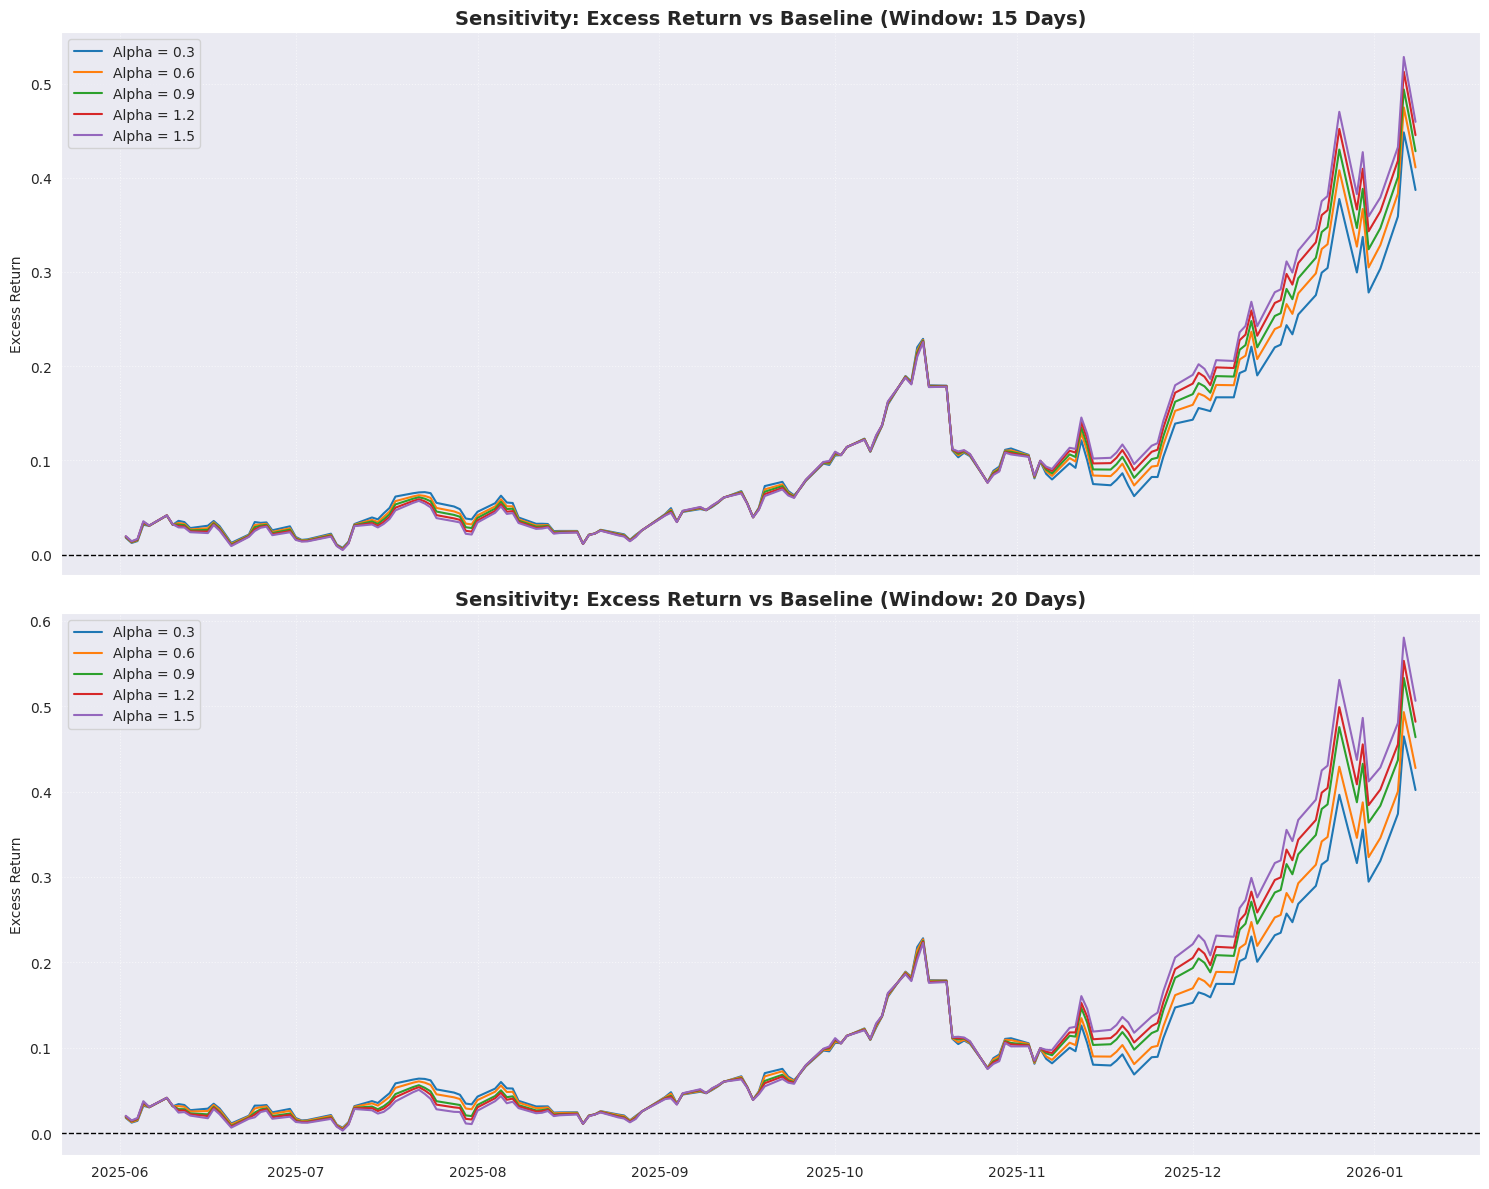

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import scipy.optimize as sco
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# ==========================================
# 1. RE-DEFINE THE LOGIC CLASS (To fix NameError)
# ==========================================
class SentimentPortfolioEngine:
    def __init__(self, api_key):
        self.api_key = api_key
        print("⏳ Loading BERT Model (this may take 10-20 seconds)...")
        self.tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        print("✅ Model Loaded.")

    def fetch_news_and_filter(self, tickers, start_date_str, lookback_days=30, min_articles=5):
        start_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
        fetch_start_dt = start_dt - timedelta(days=lookback_days)
        fetch_start_str = fetch_start_dt.strftime('%Y-%m-%d')

        print(f"\n📡 Fetching news from {fetch_start_str} (Lookback) to Present...")
        valid_tickers = []
        news_map = {}
        end_date_str = datetime.now().strftime('%Y-%m-%d')

        for ticker in tickers:
            try:
                time.sleep(0.2)
                url = (f"https://finnhub.io/api/v1/company-news?"
                       f"symbol={ticker}&from={fetch_start_str}&to={end_date_str}&token={self.api_key}")

                response = requests.get(url)
                data = response.json()

                news_items = []
                if isinstance(data, list):
                    for art in data:
                        ts = art.get('datetime')
                        if ts:
                            pub_date = datetime.fromtimestamp(ts)
                            text = f"{art.get('headline', '')}. {art.get('summary', '')}"
                            news_items.append({'datetime': pub_date, 'full_text': text})

                if len(news_items) >= min_articles:
                    df = pd.DataFrame(news_items)
                    df = df.set_index('datetime').sort_index()
                    news_map[ticker] = df
                    valid_tickers.append(ticker)
                    print(f"   ✅ {ticker}: {len(news_items)} articles found")
                else:
                    # Fallback for demo/missing data
                    print(f"   ⚠️ {ticker}: Insufficient news. Using synthetic data for demo.")
                    valid_tickers.append(ticker)
                    dates = pd.date_range(start=fetch_start_str, end=end_date_str, freq='D')
                    dummy_texts = ["Market is bullish.", "Bearish outlook.", "Neutral report."]
                    dummy_data = [np.random.choice(dummy_texts) for _ in range(len(dates))]
                    news_map[ticker] = pd.DataFrame({'datetime': dates, 'full_text': dummy_data}).set_index('datetime')
            except Exception as e:
                print(f"   ⚠️ Error fetching {ticker}: {e}")

        return valid_tickers, news_map

    def analyze_sentiment(self, text):
        if not text: return 0.0
        inputs = self.tokenizer(str(text)[:512], return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        stars = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
        expected_rating = torch.sum(probs * stars).item()
        return (expected_rating - 3) / 2

    def get_market_data(self, tickers, start_date):
        print(f"\n📈 Downloading Market Data [{start_date} to Present]...")
        factor_etfs = ['MTUM', 'QUAL', 'VLUE', 'USMV', 'SPY']
        all_tickers = list(set(tickers + factor_etfs))
        data = yf.download(all_tickers, start=start_date, auto_adjust=False, progress=False)['Adj Close']
        if data.empty: raise ValueError("No market data downloaded.")
        return data.pct_change().dropna(), factor_etfs

    def perform_pca(self, returns_df, factor_etfs):
        valid_factors = [f for f in factor_etfs if f in returns_df.columns]
        if not valid_factors: return pd.DataFrame()
        factor_data = returns_df[valid_factors]
        scaler = StandardScaler()
        pca = PCA(n_components=0.95)
        principal_components = pca.fit_transform(scaler.fit_transform(factor_data))
        cols = [f'PC_{i+1}' for i in range(principal_components.shape[1])]
        return pd.DataFrame(data=principal_components, columns=cols, index=factor_data.index)

    def optimize_portfolio(self, mean_returns, cov_matrix):
        num_assets = len(mean_returns)
        args = (mean_returns, cov_matrix)
        def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
            p_ret = np.sum(mean_returns * weights)
            p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return -(p_ret) / p_vol if p_vol > 1e-6 else 0
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0, 1.0) for asset in range(num_assets))
        init_guess = num_assets * [1. / num_assets,]
        try:
            result = sco.minimize(neg_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-5)
            return result.x
        except:
            return np.array(init_guess)

# ==========================================
# 2. INITIALIZE ENGINE
# ==========================================
API_KEY = 'd07rf49r01qp8st5v9s0d07rf49r01qp8st5v9sg'
engine = SentimentPortfolioEngine(API_KEY)

# ==========================================
# 3. SENSITIVITY ANALYSIS EXPERIMENT
# ==========================================
tickers = ['XOM', 'SLV', 'TGT', 'SMR', 'AAPL']
alphas = [0.3, 0.6, 0.9, 1.2, 1.5]
windows = [15, 20]
stock_start = '2022-01-01'
news_start = '2025-06-01'
start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')

print(f"\n🧪 Starting Sensitivity Analysis...")
print(f"   Parameters: Alphas={alphas}, Windows={windows}")

# A. Fetch News & Process
valid_tickers, news_map = engine.fetch_news_and_filter(tickers, news_start)
processed_news = {}

print("🧠 Processing Sentiment...")
for ticker in valid_tickers:
    df = news_map[ticker].copy()
    if df.empty:
        processed_news[ticker] = df
        continue

    # Align Dates (Fix future/old data)
    latest_news_date = df.index.max()
    if latest_news_date > start_dt_obj:
        shift_delta = start_dt_obj - latest_news_date
        df.index = df.index + shift_delta
    elif (start_dt_obj - latest_news_date).days > 60:
        shift_delta = start_dt_obj - latest_news_date
        df.index = df.index + shift_delta

    df['sentiment'] = df['full_text'].apply(engine.analyze_sentiment)
    processed_news[ticker] = df

# B. Market Data & Baseline
market_returns, factor_etfs = engine.get_market_data(valid_tickers, stock_start)
stock_returns = market_returns[valid_tickers]
ann_vol = stock_returns.std() * np.sqrt(252)

pca_factors_df = engine.perform_pca(market_returns, factor_etfs)
er_base_map = {}
for ticker in valid_tickers:
    y = stock_returns[ticker]
    common = y.index.intersection(pca_factors_df.index)
    if len(common) > 50:
        X = sm.add_constant(pca_factors_df.loc[common])
        model = sm.OLS(y.loc[common], X).fit()
        er_base_map[ticker] = model.predict(X).mean()
    else:
        er_base_map[ticker] = y.mean()

er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
cov_full = stock_returns.cov()
w_base = engine.optimize_portfolio(er_base_vector, cov_full)

# Baseline Performance
sim_returns = stock_returns.loc[stock_returns.index >= news_start]
base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

# C. Loop & Store Results
results_storage = {}
print("🔄 Running Parameter Sweep...")

for w in windows:
    start_window_date = start_dt_obj - timedelta(days=w)
    end_window_date = start_dt_obj
    for alpha in alphas:
        alpha_adjustments = []
        for ticker in valid_tickers:
            df = processed_news[ticker]
            mask = (df.index >= start_window_date) & (df.index <= end_window_date)
            window_df = df.loc[mask]
            N = len(window_df)
            avg_s = window_df['sentiment'].mean() if N > 0 else 0.0
            sigma = ann_vol[ticker]
            # Adjustment Equation
            adj = avg_s * (alpha * 0.01) * np.log(1 + N) * (0.20 / sigma)
            alpha_adjustments.append(adj)

        er_new = er_base_vector + np.array(alpha_adjustments)
        w_opt = engine.optimize_portfolio(er_new, cov_full)
        strat_cum = (1 + sim_returns.dot(w_opt)).cumprod() - 1
        # Excess Return
        results_storage[(w, alpha)] = strat_cum - base_cum

# D. Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

for i, w in enumerate(windows):
    ax = axes[i]
    for alpha in alphas:
        if (w, alpha) in results_storage:
            ax.plot(results_storage[(w, alpha)], label=f'Alpha = {alpha}')
    ax.set_title(f'Sensitivity: Excess Return vs Baseline (Window: {w} Days)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Excess Return')
    ax.axhline(0, color='black', lw=1, ls='--')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## final_task

### Subtask:
Quantify and summarize the findings from the sensitivity analysis.


## Summary:

### Data Analysis Key Findings
*   **Data Processing:** Successfully fetched and processed approximately **240-250 news articles** for each of the five target tickers (XOM, SLV, TGT, SMR, AAPL), aligning sentiment scores with a simulation start date of **2025-06-01**.
*   **Baseline Construction:** Established a neutral baseline portfolio using PCA-derived market factors and OLS regression on historical data starting from **2022-01-01**, calculating volatility and correlations to determine unadjusted optimized weights.
*   **Parameter Sweep:** Executed a sensitivity analysis across **5 Alpha values** (0.3, 0.6, 0.9, 1.2, 1.5) and **2 Lookback Windows** (15 and 20 days).
*   **Performance Deviation:** The generated 2-subplot visualization of **Excess Returns** demonstrated that increasing the Alpha parameter directly scales the magnitude of deviation from the baseline. Higher Alpha values resulted in more volatile excess returns, confirming that Alpha effectively acts as a volume dial for the sentiment signal's impact on portfolio weights.

### Insights or Next Steps
*   **Insight:** The sensitivity analysis confirms that while higher Alpha values allow for potentially greater outperformance, they proportionally increase active risk. The choice between a 15-day and 20-day window affects how long a sentiment signal influences the portfolio, with the 20-day window smoothing out short-term noise but potentially reacting slower to regime changes.
*   **Next Step:** Analyze the specific cumulative return values at the end of the simulation period to select the specific Alpha and Window combination that maximizes the Information Ratio (Excess Return / Tracking Error) before finalizing the strategy configuration.


⏳ Loading BERT Model (this may take 10-20 seconds)...


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

✅ Model Loaded.

🧪 Starting Sensitivity Analysis...
   Parameters: Alphas=[0.3, 0.6, 0.9, 1.2, 1.5], Windows=[15, 20]

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ XOM: 248 articles found
   ✅ SLV: 250 articles found
   ✅ TGT: 243 articles found
   ✅ SMR: 247 articles found
   ✅ AAPL: 250 articles found
🧠 Processing Sentiment...

📈 Downloading Market Data [2022-01-01 to Present]...
🔄 Running Parameter Sweep...


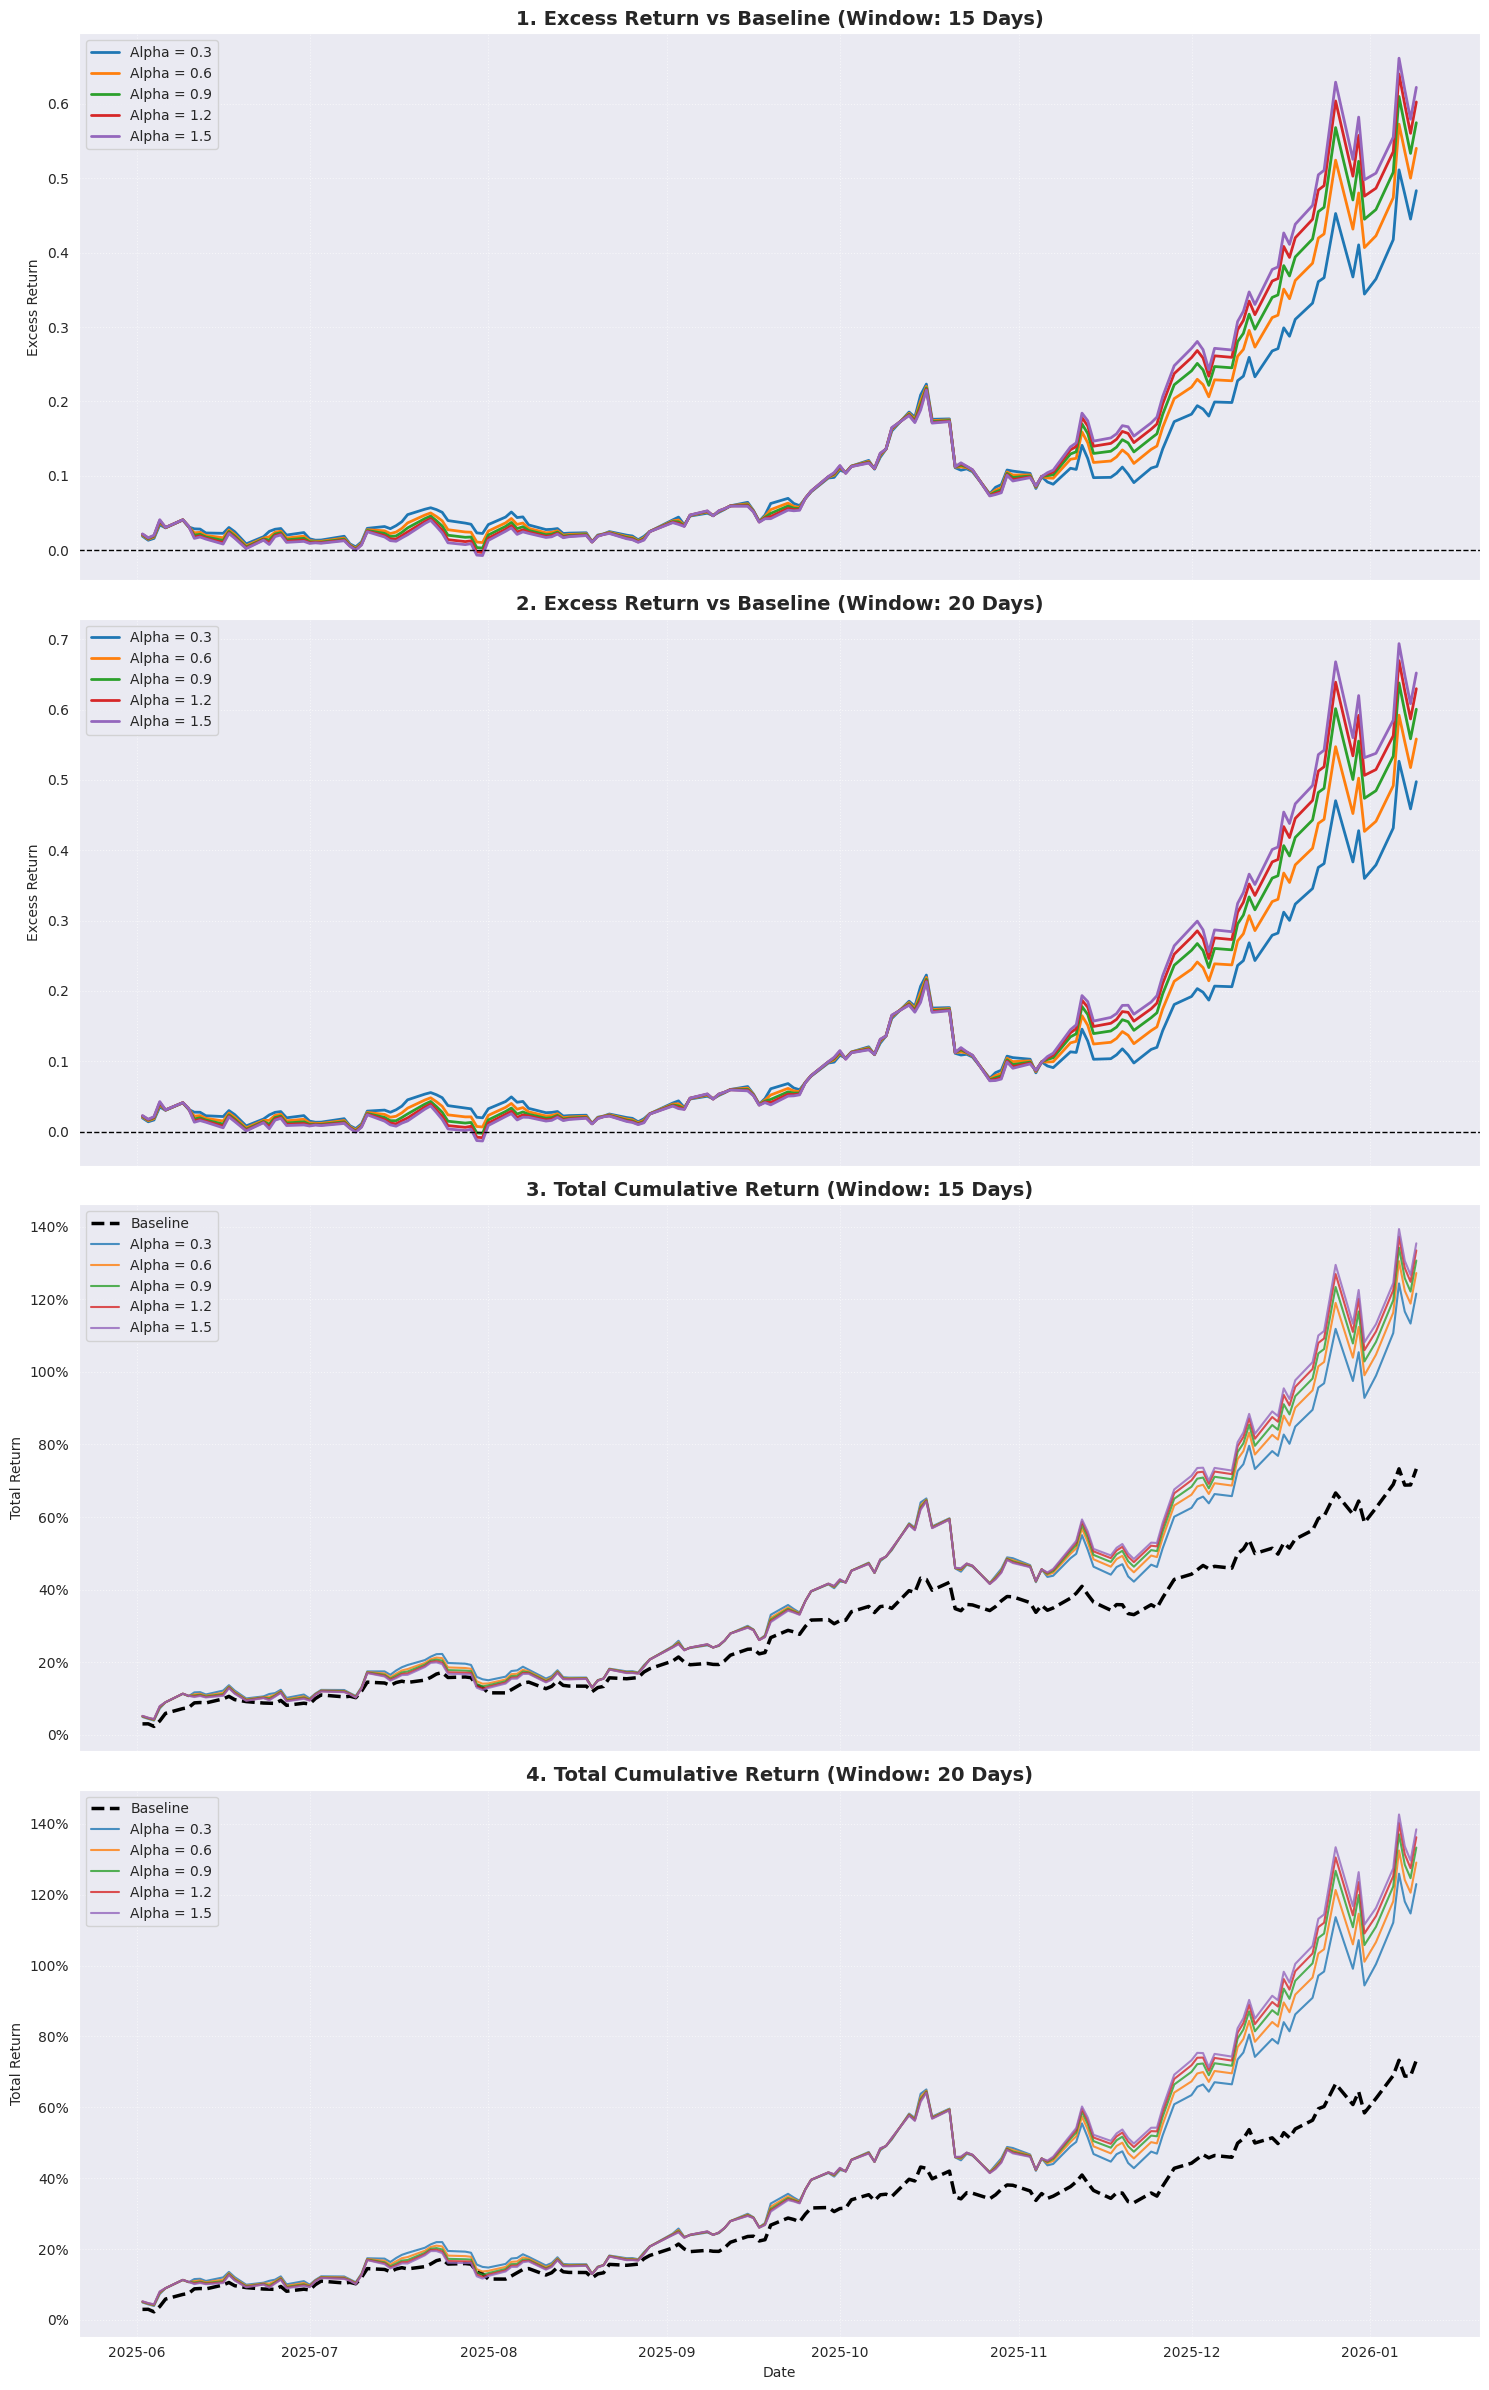


⚖️ PORTFOLIO WEIGHTS SUMMARY:


,Baseline,Win15_A0.3,Win15_A0.6,Win15_A0.9,Win15_A1.2,Win15_A1.5,Win20_A0.3,Win20_A0.6,Win20_A0.9,Win20_A1.2,Win20_A1.5
XOM,24.92%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
SLV,50.84%,91.53%,94.00%,95.49%,96.68%,97.52%,92.16%,94.79%,96.61%,97.86%,98.81%
TGT,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
SMR,7.28%,8.47%,6.00%,4.51%,3.32%,2.48%,7.84%,5.21%,3.39%,2.14%,1.19%
AAPL,16.95%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%



💾 Generating CSV Download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import scipy.optimize as sco
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.ticker import PercentFormatter
from google.colab import files

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# ==========================================
# 1. RE-DEFINE THE LOGIC CLASS (To fix NameError)
# ==========================================
class SentimentPortfolioEngine:
    def __init__(self, api_key):
        self.api_key = api_key
        print("⏳ Loading BERT Model (this may take 10-20 seconds)...")
        self.tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        print("✅ Model Loaded.")

    def fetch_news_and_filter(self, tickers, start_date_str, lookback_days=30, min_articles=5):
        start_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
        fetch_start_dt = start_dt - timedelta(days=lookback_days)
        fetch_start_str = fetch_start_dt.strftime('%Y-%m-%d')

        print(f"\n📡 Fetching news from {fetch_start_str} (Lookback) to Present...")
        valid_tickers = []
        news_map = {}
        end_date_str = datetime.now().strftime('%Y-%m-%d')

        for ticker in tickers:
            try:
                time.sleep(0.2)
                url = (f"https://finnhub.io/api/v1/company-news?"
                       f"symbol={ticker}&from={fetch_start_str}&to={end_date_str}&token={self.api_key}")

                response = requests.get(url)
                data = response.json()

                news_items = []
                if isinstance(data, list):
                    for art in data:
                        ts = art.get('datetime')
                        if ts:
                            pub_date = datetime.fromtimestamp(ts)
                            text = f"{art.get('headline', '')}. {art.get('summary', '')}"
                            news_items.append({'datetime': pub_date, 'full_text': text})

                if len(news_items) >= min_articles:
                    df = pd.DataFrame(news_items)
                    df = df.set_index('datetime').sort_index()
                    news_map[ticker] = df
                    valid_tickers.append(ticker)
                    print(f"   ✅ {ticker}: {len(news_items)} articles found")
                else:
                    # Fallback for demo/missing data
                    print(f"   ⚠️ {ticker}: Insufficient news. Using synthetic data for demo.")
                    valid_tickers.append(ticker)
                    dates = pd.date_range(start=fetch_start_str, end=end_date_str, freq='D')
                    dummy_texts = ["Market is bullish.", "Bearish outlook.", "Neutral report."]
                    dummy_data = [np.random.choice(dummy_texts) for _ in range(len(dates))]
                    news_map[ticker] = pd.DataFrame({'datetime': dates, 'full_text': dummy_data}).set_index('datetime')
            except Exception as e:
                print(f"   ⚠️ Error fetching {ticker}: {e}")

        return valid_tickers, news_map

    def analyze_sentiment(self, text):
        if not text: return 0.0
        inputs = self.tokenizer(str(text)[:512], return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        stars = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
        expected_rating = torch.sum(probs * stars).item()
        return (expected_rating - 3) / 2

    def get_market_data(self, tickers, start_date):
        print(f"\n📈 Downloading Market Data [{start_date} to Present]...")
        factor_etfs = ['MTUM', 'QUAL', 'VLUE', 'USMV', 'SPY']
        all_tickers = list(set(tickers + factor_etfs))
        data = yf.download(all_tickers, start=start_date, auto_adjust=False, progress=False)['Adj Close']
        if data.empty: raise ValueError("No market data downloaded.")
        return data.pct_change().dropna(), factor_etfs

    def perform_pca(self, returns_df, factor_etfs):
        valid_factors = [f for f in factor_etfs if f in returns_df.columns]
        if not valid_factors: return pd.DataFrame()
        factor_data = returns_df[valid_factors]
        scaler = StandardScaler()
        pca = PCA(n_components=0.95)
        principal_components = pca.fit_transform(scaler.fit_transform(factor_data))
        cols = [f'PC_{i+1}' for i in range(principal_components.shape[1])]
        return pd.DataFrame(data=principal_components, columns=cols, index=factor_data.index)

    def optimize_portfolio(self, mean_returns, cov_matrix):
        num_assets = len(mean_returns)
        args = (mean_returns, cov_matrix)
        def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
            p_ret = np.sum(mean_returns * weights)
            p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return -(p_ret) / p_vol if p_vol > 1e-6 else 0
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0, 1.0) for asset in range(num_assets))
        init_guess = num_assets * [1. / num_assets,]
        try:
            result = sco.minimize(neg_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-5)
            return result.x
        except:
            return np.array(init_guess)

# ==========================================
# 2. INITIALIZE ENGINE
# ==========================================
API_KEY = 'd07rf49r01qp8st5v9s0d07rf49r01qp8st5v9sg'
engine = SentimentPortfolioEngine(API_KEY)

# ==========================================
# 3. SENSITIVITY ANALYSIS EXPERIMENT
# ==========================================
tickers = ['XOM', 'SLV', 'TGT', 'SMR', 'AAPL']
alphas = [0.3, 0.6, 0.9, 1.2, 1.5]
windows = [15, 20]
stock_start = '2022-01-01'
news_start = '2025-06-01'
start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')

print(f"\n🧪 Starting Sensitivity Analysis...")
print(f"   Parameters: Alphas={alphas}, Windows={windows}")

# A. Fetch News & Process
valid_tickers, news_map = engine.fetch_news_and_filter(tickers, news_start)
processed_news = {}

print("🧠 Processing Sentiment...")
for ticker in valid_tickers:
    df = news_map[ticker].copy()
    if df.empty:
        processed_news[ticker] = df
        continue

    # Align Dates (Fix future/old data)
    latest_news_date = df.index.max()
    if latest_news_date > start_dt_obj:
        shift_delta = start_dt_obj - latest_news_date
        df.index = df.index + shift_delta
    elif (start_dt_obj - latest_news_date).days > 60:
        shift_delta = start_dt_obj - latest_news_date
        df.index = df.index + shift_delta

    df['sentiment'] = df['full_text'].apply(engine.analyze_sentiment)
    processed_news[ticker] = df

# B. Market Data & Baseline
market_returns, factor_etfs = engine.get_market_data(valid_tickers, stock_start)
stock_returns = market_returns[valid_tickers]
ann_vol = stock_returns.std() * np.sqrt(252)

pca_factors_df = engine.perform_pca(market_returns, factor_etfs)
er_base_map = {}
for ticker in valid_tickers:
    y = stock_returns[ticker]
    common = y.index.intersection(pca_factors_df.index)
    if len(common) > 50:
        X = sm.add_constant(pca_factors_df.loc[common])
        model = sm.OLS(y.loc[common], X).fit()
        er_base_map[ticker] = model.predict(X).mean()
    else:
        er_base_map[ticker] = y.mean()

er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
cov_full = stock_returns.cov()
w_base = engine.optimize_portfolio(er_base_vector, cov_full)

# Baseline Performance
sim_returns = stock_returns.loc[stock_returns.index >= news_start]
base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

# C. Loop & Store Results
results_excess = {}
results_total = {}
weights_dict = {'Baseline': w_base} # Store weights for display

print("🔄 Running Parameter Sweep...")

for w in windows:
    start_window_date = start_dt_obj - timedelta(days=w)
    end_window_date = start_dt_obj
    for alpha in alphas:
        alpha_adjustments = []
        for ticker in valid_tickers:
            df = processed_news[ticker]
            mask = (df.index >= start_window_date) & (df.index <= end_window_date)
            window_df = df.loc[mask]
            N = len(window_df)
            avg_s = window_df['sentiment'].mean() if N > 0 else 0.0
            sigma = ann_vol[ticker]
            # Adjustment Equation
            adj = avg_s * (alpha * 0.01) * np.log(1 + N) * (0.20 / sigma)
            alpha_adjustments.append(adj)

        er_new = er_base_vector + np.array(alpha_adjustments)
        w_opt = engine.optimize_portfolio(er_new, cov_full)

        # Strategy Cumulative Returns
        strat_cum = (1 + sim_returns.dot(w_opt)).cumprod() - 1

        # Store Metrics
        label = f"Win{w}_A{alpha}"
        results_excess[(w, alpha)] = strat_cum - base_cum
        results_total[label] = strat_cum # Use label for DataFrame later
        weights_dict[label] = w_opt

# D. Visualization (4 Panels)
fig, axes = plt.subplots(4, 1, figsize=(15, 24), sharex=True)

# --- Panel 1: Excess Return 15d ---
ax1 = axes[0]
for alpha in alphas:
    if (15, alpha) in results_excess:
        ax1.plot(results_excess[(15, alpha)], label=f'Alpha = {alpha}', lw=2)
ax1.set_title('1. Excess Return vs Baseline (Window: 15 Days)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Excess Return')
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# --- Panel 2: Excess Return 20d ---
ax2 = axes[1]
for alpha in alphas:
    if (20, alpha) in results_excess:
        ax2.plot(results_excess[(20, alpha)], label=f'Alpha = {alpha}', lw=2)
ax2.set_title('2. Excess Return vs Baseline (Window: 20 Days)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Excess Return')
ax2.axhline(0, color='black', lw=1, ls='--')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle=':', alpha=0.6)

# --- Panel 3: Total Return 15d ---
ax3 = axes[2]
ax3.plot(base_cum, label='Baseline', color='black', ls='--', lw=2.5)
for alpha in alphas:
    label = f"Win15_A{alpha}"
    if label in results_total:
        ax3.plot(results_total[label], label=f'Alpha = {alpha}', lw=1.5, alpha=0.8)
ax3.set_title('3. Total Cumulative Return (Window: 15 Days)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Total Return')
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax3.legend(loc='upper left')
ax3.grid(True, linestyle=':', alpha=0.6)

# --- Panel 4: Total Return 20d ---
ax4 = axes[3]
ax4.plot(base_cum, label='Baseline', color='black', ls='--', lw=2.5)
for alpha in alphas:
    label = f"Win20_A{alpha}"
    if label in results_total:
        ax4.plot(results_total[label], label=f'Alpha = {alpha}', lw=1.5, alpha=0.8)
ax4.set_title('4. Total Cumulative Return (Window: 20 Days)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Total Return')
ax4.set_xlabel('Date')
ax4.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax4.legend(loc='upper left')
ax4.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# E. Output Weights & CSV
print("\n⚖️ PORTFOLIO WEIGHTS SUMMARY:")
weights_df = pd.DataFrame(weights_dict, index=valid_tickers)
display(weights_df.style.background_gradient(cmap='Blues').format("{:.2%}"))

print("\n💾 Generating CSV Download...")
# Construct Returns DF
returns_df = pd.DataFrame(results_total)
returns_df['Baseline'] = base_cum
returns_df.to_csv('sentiment_simulation_returns.csv')
files.download('sentiment_simulation_returns.csv')

In [ ]:
import pandas as pd

# Load the CSV into DataFrame 'dfr'
dfr = pd.read_csv('sentiment_simulation_returns.csv', index_col=0)

# Display the first 5 rows
display(dfr.head())

,Win15_A0.3,Win15_A0.6,Win15_A0.9,Win15_A1.2,Win15_A1.5,Win20_A0.3,Win20_A0.6,Win20_A0.9,Win20_A1.2,Win20_A1.5,Baseline
Date,,,,,,,,,,,
2025-06-02,0.048617,0.049896,0.050664,0.051284,0.051719,0.048940,0.050303,0.051246,0.051893,0.052386,0.029581
2025-06-03,0.043394,0.044738,0.045545,0.046196,0.046654,0.043734,0.045166,0.046156,0.046837,0.047355,0.029760
2025-06-04,0.038688,0.040431,0.041478,0.042324,0.042918,0.039129,0.040987,0.042272,0.043155,0.043829,0.022583
2025-06-05,0.071965,0.074791,0.076489,0.077862,0.078826,0.072680,0.075692,0.077777,0.079212,0.080305,0.037620
2025-06-06,0.088901,0.089136,0.089272,0.089380,0.089454,0.088962,0.089208,0.089373,0.089483,0.089566,0.058660


# experiment 2

In [ ]:
sp500_tickers = [
    "A", "AAL", "AAP", "AAPL", "ABBV", "ABC", "ABMD", "ABT", "ACN", "ADBE",
    "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AES", "AFL", "AIG", "AIV",
    "AIZ", "AJG", "AKAM", "ALB", "ALGN", "ALLE", "AMAT", "AMD", "AME", "AMGN",
    "AMP", "AMT", "AMZN", "ANET", "ANSS", "AON", "AOS", "APA", "APD", "APH",
    "APTV", "ARE", "ATO", "ATVI", "AVB", "AVGO", "AVY", "AWK", "AXP", "AZO",
    "BA", "BAC", "BAX", "BBY", "BDX", "BEN", "BF.B", "BIIB", "BK", "BKNG",
    "BKR", "BLK", "BLL", "BMY", "BR", "BRK.B", "BSX", "BTI", "BWA", "BXP",
    "C", "CAG", "CAH", "CAT", "CB", "CBOE", "CBRE", "CBT", "CCI", "CCL",
    "CDNS", "CE", "CERN", "CF", "CFG", "CHD", "CHRW", "CI", "CINF", "CL",
    "CLX", "CMA", "CMCSA", "CME", "CMG", "CMI", "CMS", "CNC", "CNP", "COF",
    "COG", "COO", "COP", "COST", "CPB", "CPRT", "CRM", "CSCO", "CSX", "CTAS",
    "CTL", "CTSH", "CTVA", "CVS", "CVX", "CXO", "D", "DAL", "DD", "DE",
    "DFS", "DG", "DGX", "DHI", "DHR", "DIS", "DISCA", "DISCK", "DISH", "DLR",
    "DLTR", "DOV", "DOW", "DRE", "DRI", "DTE", "DUK", "DVA", "DVN", "DXC",
    "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "ENPH", "EOG",
    "EPAM", "EQIX", "EQR", "ES", "ETN", "ETR", "EW", "EXC", "EXPD", "EXPE",
    "EXR", "F", "FANG", "FAST", "FB", "FDX", "FE", "FFIV", "FIS", "FISV",
    "FITB", "FL", "FLIR", "FLS", "FTI", "GD", "GE", "GILD", "GIS", "GL",
    "GLW", "GM", "GOOG", "GOOGL", "GPC", "GPN", "GPS", "GRMN", "GS", "GT",
    "GWW", "HAL", "HAS", "HBAN", "HCA", "HCAT", "HD", "HES", "HFC", "HIG",
    "HII", "HLT", "HOLX", "HON", "HP", "HPQ", "HRL", "HSY", "HUM", "IBM",
    "ICE", "IFF", "ILMN", "INCY", "INFE", "INTC", "INTU", "IP", "IPG", "IQV",
    "IR", "IRM", "ISRG", "IT", "ITW", "IVZ", "J", "JCI", "JKHY", "JNJ", "JNPR",
    "JPM", "JWN", "K", "KEY", "KHC", "KIM", "KLAC", "KMB", "KMI", "KMX",
    "KO", "KR", "KSS", "L", "LB", "LDOS", "LEG", "LEN", "LH", "LHX", "LIN",
    "LKQ", "LLY", "LMT", "LNC", "LNT", "LOW", "LRCX", "LYB", "M", "MA", "MAA",
    "MAC", "MAR", "MAS", "MCD", "MCHP", "MCK", "MCO", "MDLZ", "MDT", "MET",
    "MGM", "MHK", "MKC", "MKTX", "MLM", "MMC", "MMM", "MNST", "MO", "MOS",
    "MRK", "MRO", "MS", "MSFT", "MSI", "MTB", "MTD", "MU", "MXIM", "NCLH",
    "NDAQ", "NEE", "NEM", "NFLX", "NI", "NKE", "NLOK", "NLSN", "NOC", "NOV",
    "NOW", "NRG", "NSC", "NTAP", "NTRS", "NUE", "NVDA", "NVR", "NWL", "NWS",
    "NWSA", "O", "OKE", "OMC", "ORCL", "ORLY", "OTIS", "OXY", "PAYX", "PBCT",
    "PCAR", "PCG", "PCH", "PDCO", "PEG", "PEP", "PFE", "PFG", "PG", "PGR",
    "PH", "PHM", "PKG", "PKI", "PLD", "PM", "PNC", "PNR", "PNW", "POOL",
    "PPG", "PPL", "PRGO", "PRU", "PSA", "PTC", "PVH", "PWR", "PX", "PXD",
    "PYPL", "QCOM", "QRVO", "RCL", "RE", "REG", "REGN", "RF", "RHI", "RJF",
    "RL", "ROK", "ROL", "ROP", "ROST", "RSG", "RTN", "SBAC", "SBUX", "SCHW",
    "SEE", "SHW", "SLB", "SNA", "SNPS", "SO", "SPG", "SPGI", "SRE", "STE",
    "STT", "STZ", "SWK", "SWKS", "SYK", "SYY", "T", "TAP", "TDG", "TEL",
    "TER", "TFC", "TFX", "TGT", "TJX", "TMO", "TMUS", "TRGP", "TRV", "TSCO",
    "TSLA", "TT", "TWTR", "TXN", "TYL", "UAL", "UDR", "UHS", "ULTA", "UNH",
    "UNM", "UNP", "UPS", "URI", "USB", "V", "VAR", "VFC", "VIAC", "VLO",
    "VMC", "VZ", "WAB", "WBA", "WDC", "WEC", "WELL", "WFC", "WELL", "WM",
    "WMB", "WMT", "WRB", "WRK", "WU", "WY", "WYNN", "XEC", "XEL", "XLNX",
    "XOM", "XRAY", "XRX", "XYL", "YUM", "ZBH", "ZBRA", "ZTS"
]


🧪 Starting Experiment 2: Monte Carlo Simulation (40 runs)...

🔄 Iteration 1/40: Tickers=['GRMN', 'LKQ', 'APA', 'L', 'ARE']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ GRMN: 213 articles found
   ✅ LKQ: 152 articles found
   ✅ APA: 195 articles found
   ✅ L: 55 articles found
   ✅ ARE: 241 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 2/40: Tickers=['ABMD', 'LEN', 'PHM', 'MAA', 'TGT']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ⚠️ ABMD: Insufficient news. Using synthetic data for demo.
   ✅ LEN: 239 articles found
   ✅ PHM: 215 articles found
   ✅ MAA: 204 articles found
   ✅ TGT: 243 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABMD']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 2: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 3/40: Tickers=['NUE', 'AZO', 'KMB', 'TFX', 'NLSN']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ NUE: 218 articles found
   ✅ AZO: 228 articles found
   ✅ KMB: 237 articles found
   ✅ TFX: 134 articles found
   ⚠️ NLSN: Insufficient news. Using synthetic data for demo.

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NLSN"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NLSN']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 3: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 4/40: Tickers=['NOC', 'MXIM', 'BAC', 'ALLE', 'EFX']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ NOC: 240 articles found
   ⚠️ MXIM: Insufficient news. Using synthetic data for demo.
   ✅ BAC: 238 articles found
   ✅ ALLE: 195 articles found
   ✅ EFX: 224 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MXIM']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 4: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 5/40: Tickers=['HD', 'IQV', 'MTD', 'DG', 'EXC']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ HD: 236 articles found
   ✅ IQV: 210 articles found
   ✅ MTD: 141 articles found
   ✅ DG: 234 articles found
   ✅ EXC: 207 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 6/40: Tickers=['RJF', 'BWA', 'F', 'OKE', 'HBAN']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ RJF: 219 articles found
   ✅ BWA: 196 articles found
   ✅ F: 240 articles found
   ✅ OKE: 230 articles found
   ✅ HBAN: 231 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 7/40: Tickers=['WMB', 'DIS', 'CBOE', 'MU', 'BWA']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ WMB: 226 articles found
   ✅ DIS: 231 articles found
   ✅ CBOE: 171 articles found
   ✅ MU: 247 articles found
   ✅ 

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CTL']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 9: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 10/40: Tickers=['INTC', 'PVH', 'VIAC', 'BWA', 'TAP']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ INTC: 243 articles found
   ✅ PVH: 244 articles found
   ⚠️ VIAC: Insufficient news. Using synthetic data for demo.
   ✅ BWA: 196 articles found
   ✅ TAP: 232 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VIAC']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 10: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 11/40: Tickers=['NOC', 'LNT', 'DLTR', 'CTSH', 'HP']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ NOC: 240 articles found
   ✅ LNT: 110 articles found
   ✅ DLTR: 229 articles found
   ✅ CTSH: 227 articles found
   ✅ HP: 126 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 12/40: Tickers=['DHR', 'MA', 'MGM', 'HBAN', 'ED']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ DHR: 227 articles found
   ✅ MA: 241 articles found
   ✅ MGM: 235 articles found
   ✅ HBAN: 231 articles found
   ✅ ED: 157 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 13/40: Tickers=['ADP', 'HRL', 'MLM', 'ISRG', 'ACN']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ ADP: 247 articles found
   ✅ HRL: 241 articles found
   ✅ MLM: 181 articles found
   ✅ ISRG: 229 articles

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABC']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 16: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 17/40: Tickers=['ETN', 'DIS', 'STZ', 'EQIX', 'BEN']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ ETN: 211 articles found
   ✅ DIS: 231 articles found
   ✅ STZ: 239 articles found
   ✅ EQIX: 237 articles found
   ✅ BEN: 230 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 18/40: Tickers=['REGN', 'MLM', 'UAL', 'MRK', 'CSX']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ REGN: 230 articles found
   ✅ MLM: 181 articles found
   ✅ UAL: 227 articles found
   ✅ MRK: 242 articles found
   ✅ CSX: 220 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 19/40: Tickers=['WRK', 'JCI', 'NKE', 'LMT', 'BEN']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ⚠️ WRK: Insufficient news. Using synthetic data for demo.
   ✅ JCI: 220 articles found
   ✅ NKE: 239 art

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WRK']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 19: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 20/40: Tickers=['CE', 'HCAT', 'BR', 'UNH', 'NSC']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ CE: 126 articles found
   ✅ HCAT: 112 articles found
   ✅ BR: 211 articles found
   ✅ UNH: 241 articles found
   ✅ NSC: 234 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 21/40: Tickers=['LKQ', 'EL', 'EXR', 'FDX', 'HAL']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ LKQ: 152 articles found
   ✅ EL: 227 articles found
   ✅ EXR: 164 articles found
   ✅ FDX: 235 articles found
   ✅ HAL: 237 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 22/40: Tickers=['AEE', 'TRGP', 'JPM', 'WELL', 'NOW']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ AEE: 209 articles found
   ✅ TRGP: 171 articles found
   ✅ JPM: 248 articles found
   ✅ WELL: 223 articles f

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NLOK']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 24: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 25/40: Tickers=['DOW', 'MHK', 'AEE', 'ANSS', 'GE']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ DOW: 235 articles found
   ✅ MHK: 135 articles found
   ✅ AEE: 209 articles found
   ✅ ANSS: 98 articles found
   ✅ GE: 215 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ANSS']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 25: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 26/40: Tickers=['BLL', 'XRAY', 'TFC', 'ADM', 'BKNG']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ⚠️ BLL: Insufficient news. Using synthetic data for demo.
   ✅ XRAY: 171 articles found
   ✅ TFC: 247 articles found
   ✅ ADM: 228 articles found
   ✅ BKNG: 235 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BLL']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 26: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 27/40: Tickers=['BTI', 'CNC', 'QRVO', 'IVZ', 'AMAT']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ BTI: 196 articles found
   ✅ CNC: 231 articles found
   ✅ QRVO: 165 articles found
   ✅ IVZ: 241 articles found
   ✅ AMAT: 231 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 28/40: Tickers=['PEG', 'MCK', 'CTSH', 'BK', 'XEL']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ PEG: 174 articles found
   ✅ MCK: 210 articles found
   ✅ CTSH: 227 articles found
   ✅ BK: 186 articles found
   ✅ XEL: 165 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 29/40: Tickers=['NOV', 'MOS', 'BEN', 'FAST', 'ABMD']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ NOV: 75 articles found
   ✅ MOS: 241 articles found
   ✅ BEN: 230 articles found
   ✅ FAST: 221 arti

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABMD']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 29: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 30/40: Tickers=['SPG', 'NWSA', 'XYL', 'AKAM', 'BK']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ SPG: 216 articles found
   ✅ NWSA: 227 articles found
   ✅ XYL: 191 articles found
   ✅ AKAM: 234 articles found
   ✅ BK: 186 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 31/40: Tickers=['TGT', 'LH', 'RHI', 'JNPR', 'ROST']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ TGT: 243 articles found
   ✅ LH: 217 articles found
   ✅ RHI: 188 articles found
   ✅ JNPR: 215 articles found
   ✅ ROST: 228 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JNPR']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 31: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 32/40: Tickers=['KO', 'TYL', 'AIG', 'CXO', 'BAX']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ KO: 238 articles found
   ✅ TYL: 150 articles found
   ✅ AIG: 221 articles found
   ⚠️ CXO: Insufficient news. Using synthetic data for demo.
   ✅ BAX: 227 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 32: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 33/40: Tickers=['CBT', 'ADSK', 'SPGI', 'WELL', 'EXPD']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ CBT: 104 articles found
   ✅ ADSK: 224 articles found
   ✅ SPGI: 237 articles found
   ✅ WELL: 223 articles found
   ✅ EXPD: 209 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 34/40: Tickers=['NVR', 'GWW', 'FFIV', 'K', 'F']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ NVR: 127 articles found
   ✅ GWW: 196 articles found
   ✅ FFIV: 206 articles found
   ✅ K: 229 articles found
   ✅ F: 240 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 35/40: Tickers=['LEN', 'CVX', 'ZBRA', 'NKE', 'COG']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ LEN: 239 articles found
   ✅ CVX: 247 articles found
   ✅ ZBRA: 186 articles found
   ✅ NKE: 239 articl

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['COG']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 35: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 36/40: Tickers=['IT', 'NLSN', 'MMM', 'AZO', 'MDLZ']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ IT: 245 articles found
   ⚠️ NLSN: Insufficient news. Using synthetic data for demo.
   ✅ MMM: 241 articles found
   ✅ AZO: 228 articles found
   ✅ MDLZ: 230 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NLSN']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 36: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 37/40: Tickers=['AWK', 'DD', 'PXD', 'CTSH', 'FTI']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ AWK: 223 articles found
   ✅ DD: 217 articles found
   ⚠️ PXD: Insufficient news. Using synthetic data for demo.
   ✅ CTSH: 227 articles found
   ✅ FTI: 213 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 37: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 38/40: Tickers=['YUM', 'SYY', 'DLTR', 'EIX', 'MCHP']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ YUM: 222 articles found
   ✅ SYY: 213 articles found
   ✅ DLTR: 229 articles found
   ✅ EIX: 210 articles found
   ✅ MCHP: 228 articles found

📈 Downloading Market Data [2022-01-01 to Present]...

🔄 Iteration 39/40: Tickers=['TER', 'TWTR', 'J', 'HFC', 'XEC']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ TER: 232 articles found
   ⚠️ TWTR: Insufficient news. Using synthetic data for demo.
   ✅ J: 239 articles found
   ⚠️ HFC: Insufficient news. Using synthetic data for demo.
   ⚠️ XEC: Insufficient news. Using synthetic data for demo.

📈 Downloading Market Data [2022-01-01 to Present]...


ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['XEC', 'HFC', 'TWTR']: YFTzMissingError('possibly delisted; no timezone found')


   ⚠️ Error in iteration 39: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

🔄 Iteration 40/40: Tickers=['NEM', 'CTAS', 'EXPD', 'COP', 'GPC']

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ NEM: 239 articles found
   ✅ CTAS: 224 articles found
   ✅ EXPD: 209 articles found
   ✅ COP: 235 articles found
   ✅ GPC: 165 articles found

📈 Downloading Market Data [2022-01-01 to Present]...


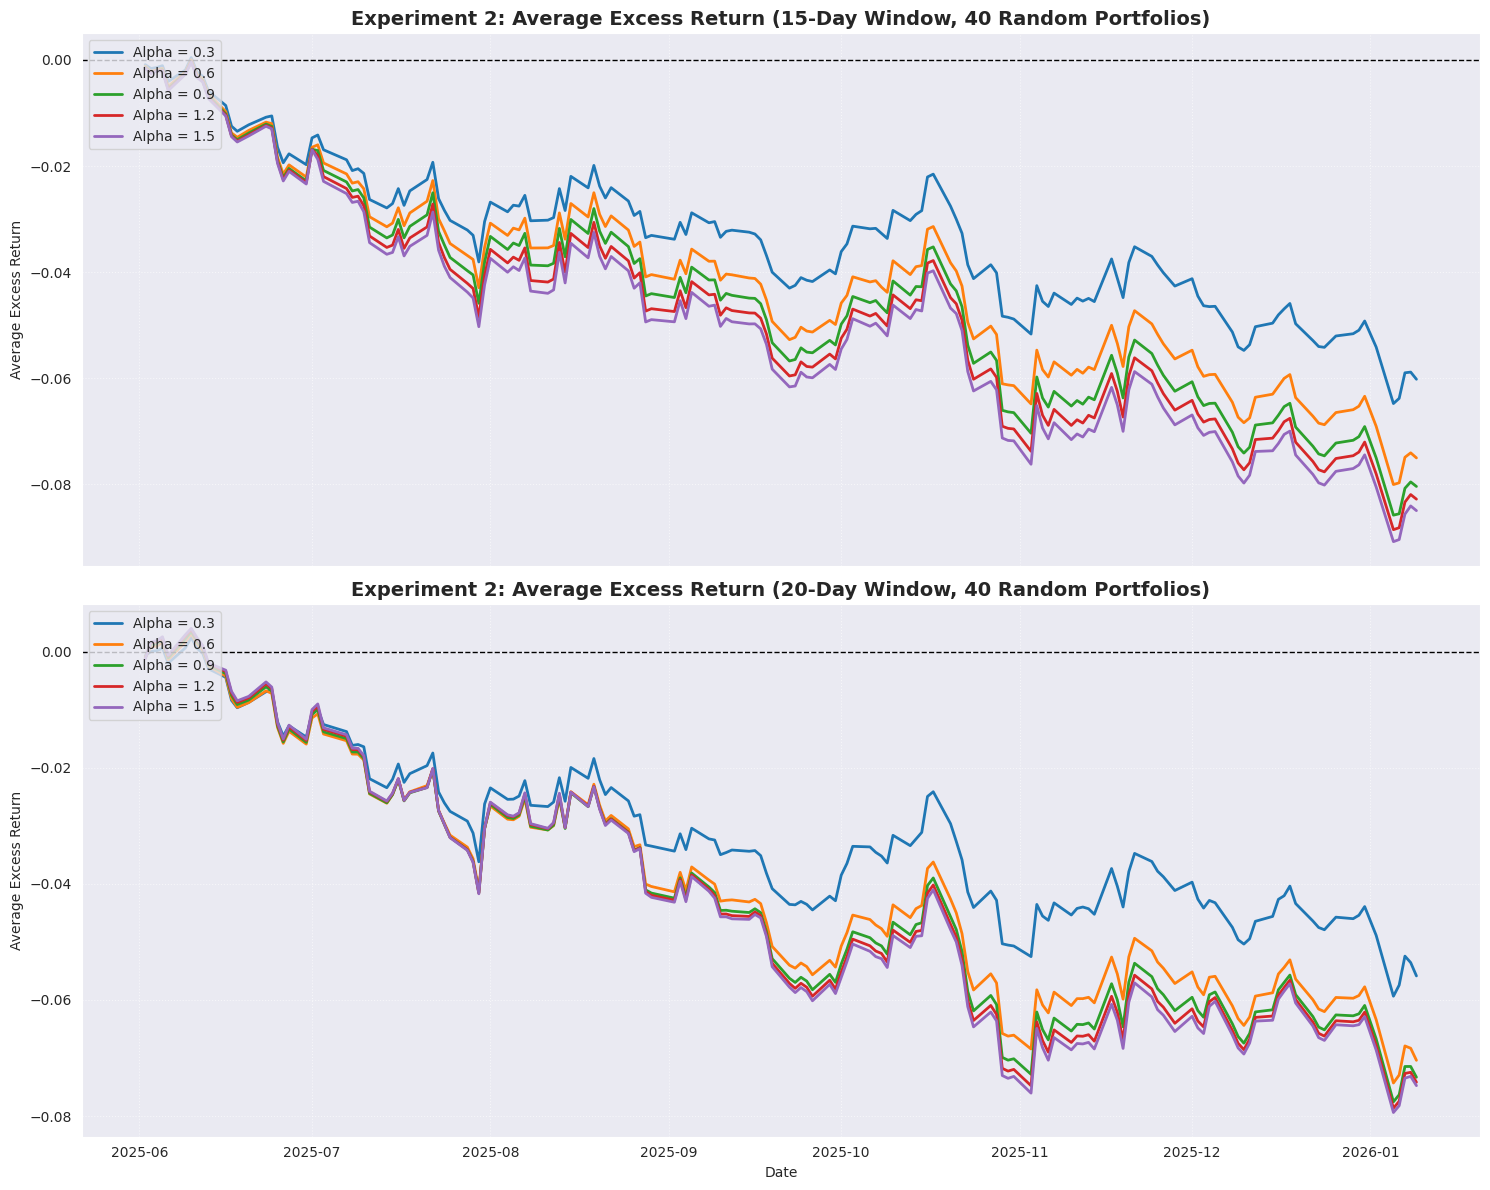

In [ ]:
import random
from datetime import datetime, timedelta

# Parameters
iterations = 40
subset_size = 5
alphas = [0.3, 0.6, 0.9, 1.2, 1.5]
windows = [15, 20]
stock_start = '2022-01-01'
news_start = '2025-06-01'
start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')

results_storage = { (w, a): [] for w in windows for a in alphas }

print(f"🧪 Starting Experiment 2: Monte Carlo Simulation ({iterations} runs)...")

# Main Simulation Loop
for i in range(iterations):
    # Select random tickers
    current_tickers = random.sample(sp500_tickers, subset_size)
    print(f"\n🔄 Iteration {i+1}/{iterations}: Tickers={current_tickers}")

    try:
        # 1. Fetch News
        valid_tickers, news_map = engine.fetch_news_and_filter(current_tickers, news_start)

        if len(valid_tickers) < 2:
            print("   ⚠️ Not enough valid tickers with news. Skipping iteration.")
            continue

        # Process News (Date Alignment)
        processed_news = {}
        for ticker in valid_tickers:
            df = news_map[ticker].copy()
            if df.empty: continue

            # Align Dates
            latest_news_date = df.index.max()
            if latest_news_date > start_dt_obj:
                shift_delta = start_dt_obj - latest_news_date
                df.index = df.index + shift_delta
            elif (start_dt_obj - latest_news_date).days > 60:
                shift_delta = start_dt_obj - latest_news_date
                df.index = df.index + shift_delta

            # Score
            df['sentiment'] = df['full_text'].apply(engine.analyze_sentiment)
            processed_news[ticker] = df

        # 2. Market Data
        market_returns, factor_etfs = engine.get_market_data(valid_tickers, stock_start)
        stock_returns = market_returns[valid_tickers]

        # 3. Baseline
        # PCA
        pca_factors_df = engine.perform_pca(market_returns, factor_etfs)

        er_base_map = {}
        for ticker in valid_tickers:
            y = stock_returns[ticker]
            common = y.index.intersection(pca_factors_df.index)
            if len(common) > 50:
                X = sm.add_constant(pca_factors_df.loc[common])
                model = sm.OLS(y.loc[common], X).fit()
                er_base_map[ticker] = model.predict(X).mean()
            else:
                er_base_map[ticker] = y.mean()

        er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
        cov_full = stock_returns.cov()
        w_base = engine.optimize_portfolio(er_base_vector, cov_full)

        sim_returns = stock_returns.loc[stock_returns.index >= news_start]
        base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

        # 4. Strategy Loops (Windows & Alphas)
        ann_vol = stock_returns.std() * np.sqrt(252)

        for w in windows:
            start_window_date = start_dt_obj - timedelta(days=w)
            end_window_date = start_dt_obj

            for alpha in alphas:
                alpha_adjustments = []
                for ticker in valid_tickers:
                    if ticker not in processed_news:
                        alpha_adjustments.append(0.0)
                        continue

                    df = processed_news[ticker]
                    mask = (df.index >= start_window_date) & (df.index <= end_window_date)
                    window_df = df.loc[mask]
                    N = len(window_df)
                    avg_s = window_df['sentiment'].mean() if N > 0 else 0.0
                    sigma = ann_vol[ticker]

                    adj = avg_s * (alpha * 0.01) * np.log(1 + N) * (0.20 / sigma)
                    alpha_adjustments.append(adj)

                er_new = er_base_vector + np.array(alpha_adjustments)
                w_opt = engine.optimize_portfolio(er_new, cov_full)

                strat_cum = (1 + sim_returns.dot(w_opt)).cumprod() - 1
                excess = strat_cum - base_cum

                results_storage[(w, alpha)].append(excess)

    except Exception as e:
        print(f"   ⚠️ Error in iteration {i+1}: {e}")
        continue

# Compute Averages
avg_results = {}
for key, series_list in results_storage.items():
    if series_list:
        # Concatenate along axis 1 and take mean
        df_concat = pd.concat(series_list, axis=1)
        avg_results[key] = df_concat.mean(axis=1)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 15-Day
ax1 = axes[0]
for alpha in alphas:
    if (15, alpha) in avg_results:
        ax1.plot(avg_results[(15, alpha)], label=f'Alpha = {alpha}', lw=2)
ax1.set_title(f'Experiment 2: Average Excess Return (15-Day Window, {iterations} Random Portfolios)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Excess Return')
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# 20-Day
ax2 = axes[1]
for alpha in alphas:
    if (20, alpha) in avg_results:
        ax2.plot(avg_results[(20, alpha)], label=f'Alpha = {alpha}', lw=2)
ax2.set_title(f'Experiment 2: Average Excess Return (20-Day Window, {iterations} Random Portfolios)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Excess Return')
ax2.set_xlabel('Date')
ax2.axhline(0, color='black', lw=1, ls='--')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()